# main.ipynb

\<< Short description >>

Authors: Angelo D. Bonzanini, Giorgos Makrygiorgos, and Victor Miller \\
(c) January 2021

## Requirements:
* Add any particular modules that need to be installed
* Add any files that need to be in the same folder (e.g., ResNet.ipynb)
* Python version
* etc.

\<< Write some basic documentation here >>

## Setting up the environment and importing modules

* First, we import standard libraries such as matplotlib, numpy, etc. If a library (e.g., casadi) is not installed create a new cell and type:
```
!pip install casadi
```

* Because .ipynb files arenot .py files, we cannot readily import them as we would a .py file. Forunately, we can use the [import_ipynb](https://pypi.org/project/import-ipynb/) module to import .ipynb files. We just need to make sure that we change the directory to wherever the .ipynb file is located.

* Note: if you are using Google colab, we need to make sure that we are installing the libraries on our Google drive folder. Otherwise, next time we open the notebook we will have to re-install the libraries. To circumvent this issue, we we first need to give access to the colab notebook to read the Google Drive (using ```drive.mount()```) and then use pip with a target, i.e.,
```
!pip install --target=$path casadi
```


In [17]:
# Import libraries
import os, sys
import matplotlib.pyplot as plt
from casadi import *
import import_ipynb
import numpy as np

In [18]:
import matlab.engine
eng = matlab.engine.start_matlab()

In [19]:
def plantDynamics(matlabEngine, xAll, z):
    # Define the parameters whose scope is limited to this function
    p1 = 82.3
    p2 = 1.0
    p3 = 0.8
    
    # Convert np arrays to list and then to matlab.double
    xMatlab = matlab.double(xAll.tolist())
    zMatlab = [matlab.double([z[0,0]]), matlab.double([z[0,1]])]
    
    # Call the BCR_Discrete function and convert it to np.array since it is matlab type intially
    xNext = np.array(matlabEngine.BCR_Discrete(xMatlab, zMatlab[0], zMatlab[1], p1, p2, p3))
    
    return xNext

In [73]:
#Load the Wmat file generated after training the neural network initial model
import pickle as pkl
#with open("weights_initialization.npy", 'wb') as f:
fileObject_load = open("weights_initialization.npy", 'rb')
Wmat = pkl.load(fileObject_load)

In [21]:
import scipy.io
model_data = scipy.io.loadmat('Data.mat')

In [22]:
Zin=model_data.get("Zin")
Zout=model_data.get("Zout")

In [23]:
initial_cond_plant =scipy.io.loadmat('init_cond.mat')
xo = initial_cond_plant.get("yo")

## Define a class that intializes all of the parameters and instantiate object

In [24]:
# Note that classes are conventionally defined with a capital first letter
class Parameters:
    # The __init__() function is like a constructor 
    #(can give it arguments if we want to intialize some parameters depending on how we instantiate the class)
    def __init__(self): 

        # Constants (conventionally with all-capitals)
        self.VIN = 1
        self.TSAMP = 1.0
        self.AREA = 0.002436 # reactor cross-sectional area (m^2)
        self.L = 1.06        # reactor length (m)
        

        # Neural Net parameters
        self.n_hidden_layers = 3 
        self.n_nodes = 5
        # self.weights
        # self.biases

        # Horizon lengths
        self.Np =  3    # Prediction horizon
        self.Nsim = 40   # Simulation horizon
        self.Nmc = 1      # Monte Carlo simulations (maybe we won't need this)

        # Cost matrices and variable sizes
        self.nx = 3
        self.nu = 2
        # If we had a tracking objective, we would define Q and R here, too 

        # Variable bounds (as a list, not a numpy array)
        self.xMin = [0.0]*self.nx
        self.xMax = [999]*self.nx
        self.uMin = [0.02, 0.3]
        self.uMax = [0.1, 0.8]

        # Initial state vectors (as a list, not a numpy array)
        zInit = model_data.get("Zin")
        xo = initial_cond_plant.get("yo")
        
        self.xInit = zInit[0,-3:].tolist()
        self.zInit = zInit[0,:].tolist()
        self.xAll = xo
        

p = Parameters()

## Modify any functions that need to take CasADi variables as inputs

Here, we redefine the ```predictive_model_resnet(z, W)``` function.


In [25]:
def predictive_model_resnet(zk,Wmat, p): 
    #Assuming you can pass extra arguments to the function for casadi, otherwsise
    #Number of hidden layers and nodes are given once when we get the optimal resnet
    #The Bayesian Optimization Loop will be changing 
    n_hidden_layers = p.n_hidden_layers
    n_nodes = p.n_nodes
    model_input = reshape(zk,1,p.nu+p.nx)
    Wmat_shape = Wmat.shape[0]
    
    #Initialize from input 
    sum0 = mtimes(model_input,Wmat[0]).T #Matrix multiplication weights*inputs
    sumbias0 = sum0 + Wmat[1] #Add bias to construct y = sum(wi*xi) + b
    #neuron_out = swish_eval(sum1bias)
    neuron_out = sumbias0/(1+exp(-sumbias0)) #explicitly writing swish activation, out = fact(y)
    #They are vector quantitites so you might need to change stuff a bit with symbolic vars
#     print(neuron_out.shape)

    #Forward prediction in hidden layers
    for k in range(n_hidden_layers-1):
        sum0 = mtimes(neuron_out.T,Wmat[2*k+2]).T
        sumbias0 = sum0 + Wmat[2*k+3]
        neuron_out = sumbias0/(1+exp(-sumbias0)) #explicitly writing swish activation

    #Final output layer with linear activation
    sum0 = mtimes(neuron_out.T,Wmat[Wmat_shape-2]).T
    sumbias0 = sum0 + Wmat[Wmat_shape-1]
    neuron_out = sumbias0  #linear activation

    return neuron_out.T #+ model_input[0,2:5]

In [26]:
# Define augmented state vector for PDE
xAll = p.xAll

# Define augmented vector of concatenated states and inputs
zk=np.array(p.zInit)
print('zk = ', zk)

# Evaluate neural net prediction 
#xkplusone_neural = DropModel.predict(zk.reshape(1,-1))
#print('x+ from DropModel = ', xkplusone_neural)
xkplusone = predictive_model_resnet(DM(zk),Wmat, p)
print('x+ from predictive_model_resnet = ', xkplusone)

# Evaluate plant model prediction
xkplusonePlant = plantDynamics(eng, xAll, zk.reshape(1,-1))
print('x+ plant = ', xkplusonePlant[0,-3:])

zk =  [0.02       0.42545237 0.2        0.05       0.0085    ]
x+ from predictive_model_resnet =  [[0.203621, 0.0294471, 0.0117836]]
x+ plant =  [0.2072488  0.06737863 0.01429066]


Embed DropModel into a CasADi function
(DO NOT USE - still in experimental stage)

In [27]:
'''
nd=4
class dropModelCasadi(Callback):
  def __init__(self, name,  opts={}):
    Callback.__init__(self)
    self.construct(name, opts)

  # Number of inputs and outputs
  def get_n_in(self): return 1
  def get_n_out(self): return 1
  
  def get_sparsity_in(self,i):
      return Sparsity.dense(1,len(zk))

  def get_sparsity_out(self,i):
      return Sparsity.dense(1,len(xk))

  # Evaluate numerically
  def eval(self, arg):
    out = DropModel.predict(np.array(arg[0]))
    return [out]


dropModelFn = dropModelCasadi('dropModelCasadi', {"enable_fd":True})

zz = MX.sym('zz', 1, 4)
print(zk)
xNNvar = dropModelFn(zz)
xNN2 = dropModelFn(zk.reshape(1,4))
print(xNN2)
print(xkplusone_neural) 
'''

'\nnd=4\nclass dropModelCasadi(Callback):\n  def __init__(self, name,  opts={}):\n    Callback.__init__(self)\n    self.construct(name, opts)\n\n  # Number of inputs and outputs\n  def get_n_in(self): return 1\n  def get_n_out(self): return 1\n  \n  def get_sparsity_in(self,i):\n      return Sparsity.dense(1,len(zk))\n\n  def get_sparsity_out(self,i):\n      return Sparsity.dense(1,len(xk))\n\n  # Evaluate numerically\n  def eval(self, arg):\n    out = DropModel.predict(np.array(arg[0]))\n    return [out]\n\n\ndropModelFn = dropModelCasadi(\'dropModelCasadi\', {"enable_fd":True})\n\nzz = MX.sym(\'zz\', 1, 4)\nprint(zk)\nxNNvar = dropModelFn(zz)\nxNN2 = dropModelFn(zk.reshape(1,4))\nprint(xNN2)\nprint(xkplusone_neural) \n'

## Define variables, constraints, and functions

Use classes to organize the code

# Objective Function
Area = 0.002436;   % reactor cross-sectional area, m^2 \
L = 1.06;   % reactor length, m  \
Qmedia[j] = Area \times L \times Dk[j]  (Dk is u[0], i.e., dilution rate) \
Try to maximize sum (Qmedia[j]*x1[j] ) (m3/h * mmol/m^3)  \
Constraints:
Selectivity is defined as Ce/Ca or x2/x1 and I want it to be x2/x1 < 0.45 \
u[0] in (0.01, 0.25) \
u[1] in (0.0, 0.9) \ 
x0,x1,x2 > 0 


In [28]:
class CasadiVars:
    def __init__(self, p):
        self.x = MX.sym("x", p.nx)
        self.u = MX.sym("u", p.nu)


class CasadiFunctions:
    def __init__(self, p, vars):
        # xNext = eulerPlantNext(vertcat(vars.u, vars.x))
        xNext = predictive_model_resnet(vertcat(vars.u, vars.x).T, Wmat, p).T
        Lstage = -p.AREA * p.L * vars.u[0] * vars.x[0]
        self.dynamics = Function('dynamics', [vars.u, vars.x], [xNext], ['u', 'x'], ['xNext'])
        self.stageCost = Function('stageCost', [vars.u, vars.x], [Lstage], ['u', 'x'], ['Lstage'])

# class NonlinearConstraints:
#   # Define any additional constraints that cannot be expressed in the form xMin <= x <= xMax (not needed at the moment)
#   def __init__(self, x, p):
      # Use CasADi function syntax

class SaveTrajectory:
    def __init__(self, p):

        # Predicted variables
        self.xOptPred = np.zeros((p.nx, p.Np+1))
        self.uOptPred = np.zeros((p.nu, p.Np))

        # Real variables
        self.xOptReal = np.zeros((p.nx, p.Nsim+1))
        self.uOptReal = np.zeros((p.nu,p.Nsim))
        self.costFunctionReal = np.zeros((p.Nsim,1))

        # Assign initial conditions
        self.costFnReal = 0;
        self.xOptReal = np.zeros((p.nx,p.Nsim+1))
        self.xOptReal[:,0] = np.array(p.xInit).reshape(p.nx,)

## Class that creates the optimal control problem (OCP)



In [29]:
class OptimalControlProblem:
    def __init__(self, Parameters, CasadiVars, CasadiFunctions):
        # Start with an empty NLP
        self.w=[]    #Array of all the variables we will be optimizing over
        self.w0 = []
        self.lbw = []
        self.ubw = []
        self.J = 0
        self.g=[]
        self.lbg = []
        self.ubg = []

        # "Lift" initial conditions
        Xk = MX.sym('X0', Parameters.nx)
        self.w += [Xk]
        self.lbw += Parameters.xInit
        self.ubw += Parameters.xInit
        self.w0  += Parameters.xInit

        for i in range(0, Parameters.Np):
            # New NLP variable for the control inputs
            Uk = MX.sym('U_' + str(i), Parameters.nu)
            self.w   += [Uk]
            self.lbw += Parameters.uMin
            self.ubw += Parameters.uMax
            self.w0  += Parameters.uMin

            # Integrate model and calculate stage cost
            xkNext = CasadiFunctions.dynamics(Uk, Xk)
            Zk = reshape(vertcat(Uk, Xk),1,Parameters.nu+Parameters.nx)
            # xkNext = reshape(CasadiFunctions.dropModel(Zk),Parameters.nx,1)
            JNext = CasadiFunctions.stageCost(Uk, Xk)
            self.J = self.J + JNext

            # New NLP variable for states at the next time-step
            Xk = MX.sym('X_' + str(i+1), Parameters.nx)
            self.w   += [Xk]
            self.lbw += Parameters.xMin
            self.ubw += Parameters.xMax
            self.w0  += [0]*Parameters.nx

            # Equality constraints (model dynamics)
            self.g   += [xkNext-Xk]
            self.lbg += [0]*Parameters.nx
            self.ubg += [0]*Parameters.nx
            
            # Inequality constraints (selectivity)
            self.g   += [Xk[2]-0.4*Xk[1]]
            self.lbg += [-inf]
            self.ubg += [0]

        # Terminal cost and constraints (if applicable)
        # N/A

        # Create NLP solver
        self.prob = {'f': self.J, 'x': vertcat(*self.w), 'g': vertcat(*self.g)}
        self.sol_opts = {'ipopt.print_level':1, 'ipopt.max_cpu_time':1.5, 'ipopt.hessian_approximation':'limited-memory'}
        self.solver = nlpsol('solver', 'ipopt', self.prob, self.sol_opts)    

        # Store variable dimensions for easy indexing
        self.offsetX0 = 0
        self.offsetU = Parameters.nx
        self.offsetOCP = Parameters.nx + Parameters.nu
     

In [30]:
# Create objects to instantiate the classes defined above
vars = CasadiVars(p)
s = SaveTrajectory(p)
fn = CasadiFunctions(p, vars)
# Create OCP object
OCP = OptimalControlProblem(p, vars, fn)

# Test (remove in the final version)
xNext1 = plantDynamics(eng, p.xAll, zk.reshape(1,-1))
xNext2 = fn.dynamics(DM(zk[0:2]), DM(zk[2:]))
print(zk)
print(xNext1[0,-3:])
print(xNext2)
print('Initial condition = ', p.xInit)

[0.02       0.42545237 0.2        0.05       0.0085    ]
[0.2072488  0.06737863 0.01429066]
[0.203621, 0.0294471, 0.0117836]
Initial condition =  [0.2, 0.05, 0.0085]


In [31]:
print(OCP.lbw)

[0.2, 0.05, 0.0085, 0.02, 0.3, 0.0, 0.0, 0.0, 0.02, 0.3, 0.0, 0.0, 0.0, 0.02, 0.3, 0.0, 0.0, 0.0]


## Closed-loop Simulation

In [32]:
# Set the initial condition and save the trajectory
xAll = p.xAll
x0real = xAll[0,-3:]
s.xOptReal[:,0] = x0real

for k in range(0, p.Nsim):

    print("Iteration %i of %i" %(k+1, p.Nsim))

    # Update OCP constraints on initial state
    OCP.lbw[OCP.offsetX0:OCP.offsetX0+p.nx] = x0real
    OCP.ubw[OCP.offsetX0:OCP.offsetX0+p.nx] = x0real
    OCP.w0[OCP.offsetX0:OCP.offsetX0+p.nx] = x0real

    # Solve the NLP
    sol = OCP.solver(x0=OCP.w0, lbx=OCP.lbw, ubx=OCP.ubw, lbg=OCP.lbg, ubg=OCP.ubg)
    w_opt = sol['x'].full().flatten()
    J_opt = sol['f'].full().flatten()

    # Extract first optimal input
    uOpt = w_opt[OCP.offsetU:OCP.offsetOCP]

    # Plant model
    zReal = np.concatenate((uOpt, x0real))
    xAll = plantDynamics(eng, xAll, zReal.reshape(1,-1))
    x0real = xAll[0,-3:]
    # Save the trajectory
    s.uOptReal[:,k] = uOpt
    print(uOpt)
    s.xOptReal[:,k+1] = x0real*(1 + 0.05*np.random.normal(0, 0.1, size=(3, 1)).reshape(3,))

# print(s.uOptReal)
# print(s.xOptReal)


Iteration 1 of 40
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   3.44ms (  2.67us)   3.40ms (  2.63us)      1290
       nlp_g  |  14.88ms ( 11.54us)  14.94ms ( 11.58us)      1290
  nlp_grad_f  |   7.04ms (  5.46us)   7.08ms (  5.48us)      1291
   nlp_jac_g  |  52.19ms ( 40.43us)  52.53ms ( 40.69us)      1291
       total  |   1.97 s (  1.97 s)   1.97 s (  1.97 s)         1
[0.09999999 0.6722498 ]
Iteration 2 of 40
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   3.04ms (  2.54us)   2.98ms (  2.49us)      1199
       nlp_g  |  12.70ms ( 10.59us)  12.88ms ( 10.74us)      1199
  nlp_grad_f  |   5.99ms (  4.99us)   5.94ms (  4.95us)      1200
   nlp_jac_g  |  45.38ms ( 37.81us)  45.79ms ( 38.16us)      1200
       total  |   1.89 s (  1.89 s)   1.90 s (  1.90 s)         1
[0.09999999 0.69482647]
Iteration 3 of 40
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   2.89ms (  2.43us)   2.

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   2.97ms (  2.29us)   2.96ms (  2.28us)      1297
       nlp_g  |  12.39ms (  9.56us)  12.48ms (  9.62us)      1297
  nlp_grad_f  |   6.04ms (  4.66us)   5.98ms (  4.61us)      1298
   nlp_jac_g  |  45.43ms ( 35.00us)  46.12ms ( 35.53us)      1298
       total  |   1.90 s (  1.90 s)   1.91 s (  1.91 s)         1
[0.09999999 0.53381385]
Iteration 21 of 40
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.15ms (  2.07us)   1.17ms (  2.10us)       556
       nlp_g  |   4.86ms (  8.74us)   4.88ms (  8.78us)       556
  nlp_grad_f  |   2.23ms (  4.01us)   2.28ms (  4.09us)       557
   nlp_jac_g  |  17.55ms ( 31.51us)  17.70ms ( 31.78us)       557
       total  | 686.68ms (686.68ms) 687.54ms (687.54ms)         1
[0.09999999 0.79999957]
Iteration 22 of 40
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   2.73ms (  2.08us)   2.77ms (  2.11us) 

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   2.29ms (  2.28us)   2.31ms (  2.29us)      1007
       nlp_g  |   9.89ms (  9.82us)   9.91ms (  9.84us)      1007
  nlp_grad_f  |   4.65ms (  4.62us)   4.69ms (  4.65us)      1008
   nlp_jac_g  |  36.28ms ( 35.99us)  36.43ms ( 36.14us)      1008
       total  |   1.52 s (  1.52 s)   1.52 s (  1.52 s)         1
[0.09999998 0.79999954]
Iteration 40 of 40
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 276.00us (  2.38us) 270.09us (  2.33us)       116
       nlp_g  |   1.13ms (  9.74us)   1.13ms (  9.74us)       116
  nlp_grad_f  | 548.00us (  4.85us) 547.78us (  4.85us)       113
   nlp_jac_g  |   4.15ms ( 36.73us)   4.17ms ( 36.94us)       113
       total  | 171.36ms (171.36ms) 171.47ms (171.47ms)         1
[0.09999998 0.79999956]


## Plot Trajectories

<IPython.core.display.Javascript object>


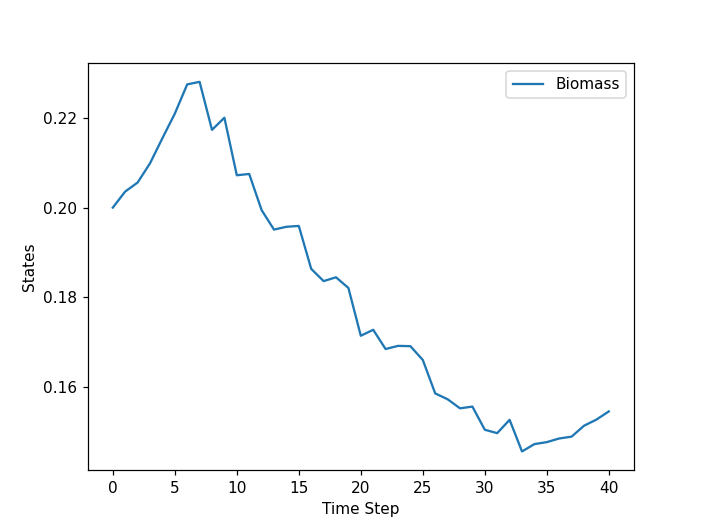

<IPython.core.display.Javascript object>


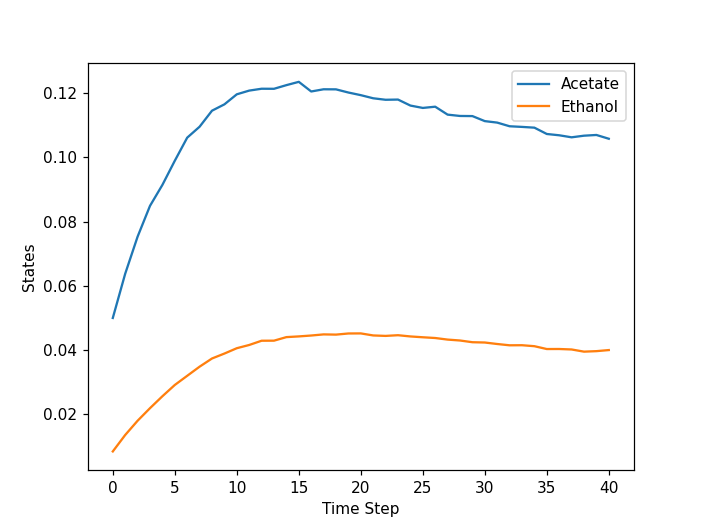

<IPython.core.display.Javascript object>


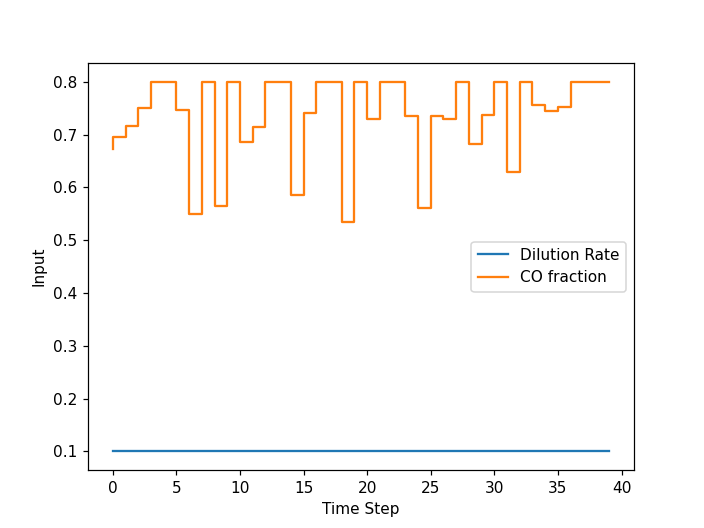

In [33]:
%matplotlib notebook
plt.figure(dpi=50)
plt.plot(s.xOptReal[0,:],label='Biomass')
plt.xlabel('Time Step')
plt.ylabel('States')
plt.legend()
plt.show()

plt.figure(dpi=50)
plt.plot(s.xOptReal[1,:],label='Acetate')
plt.plot(s.xOptReal[2,:],label='Ethanol')
plt.xlabel('Time Step')
plt.ylabel('States')
plt.legend()
plt.show()

plt.figure(dpi=50)
plt.step(range(0,p.Nsim), s.uOptReal[0,:],label='Dilution Rate')
plt.step(range(0,p.Nsim), s.uOptReal[1,:],label='CO fraction')
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('Input')
plt.show()


#plt.figure()
#plt.step(range(0,p.Nsim), s.xOptReal[1,:]/s.xOptReal[2,:],label='Dilution Rate')
#plt.legend()
#plt.xlabel('Time Step')
#plt.ylabel('Selectivity')
#plt.show()

<IPython.core.display.Javascript object>


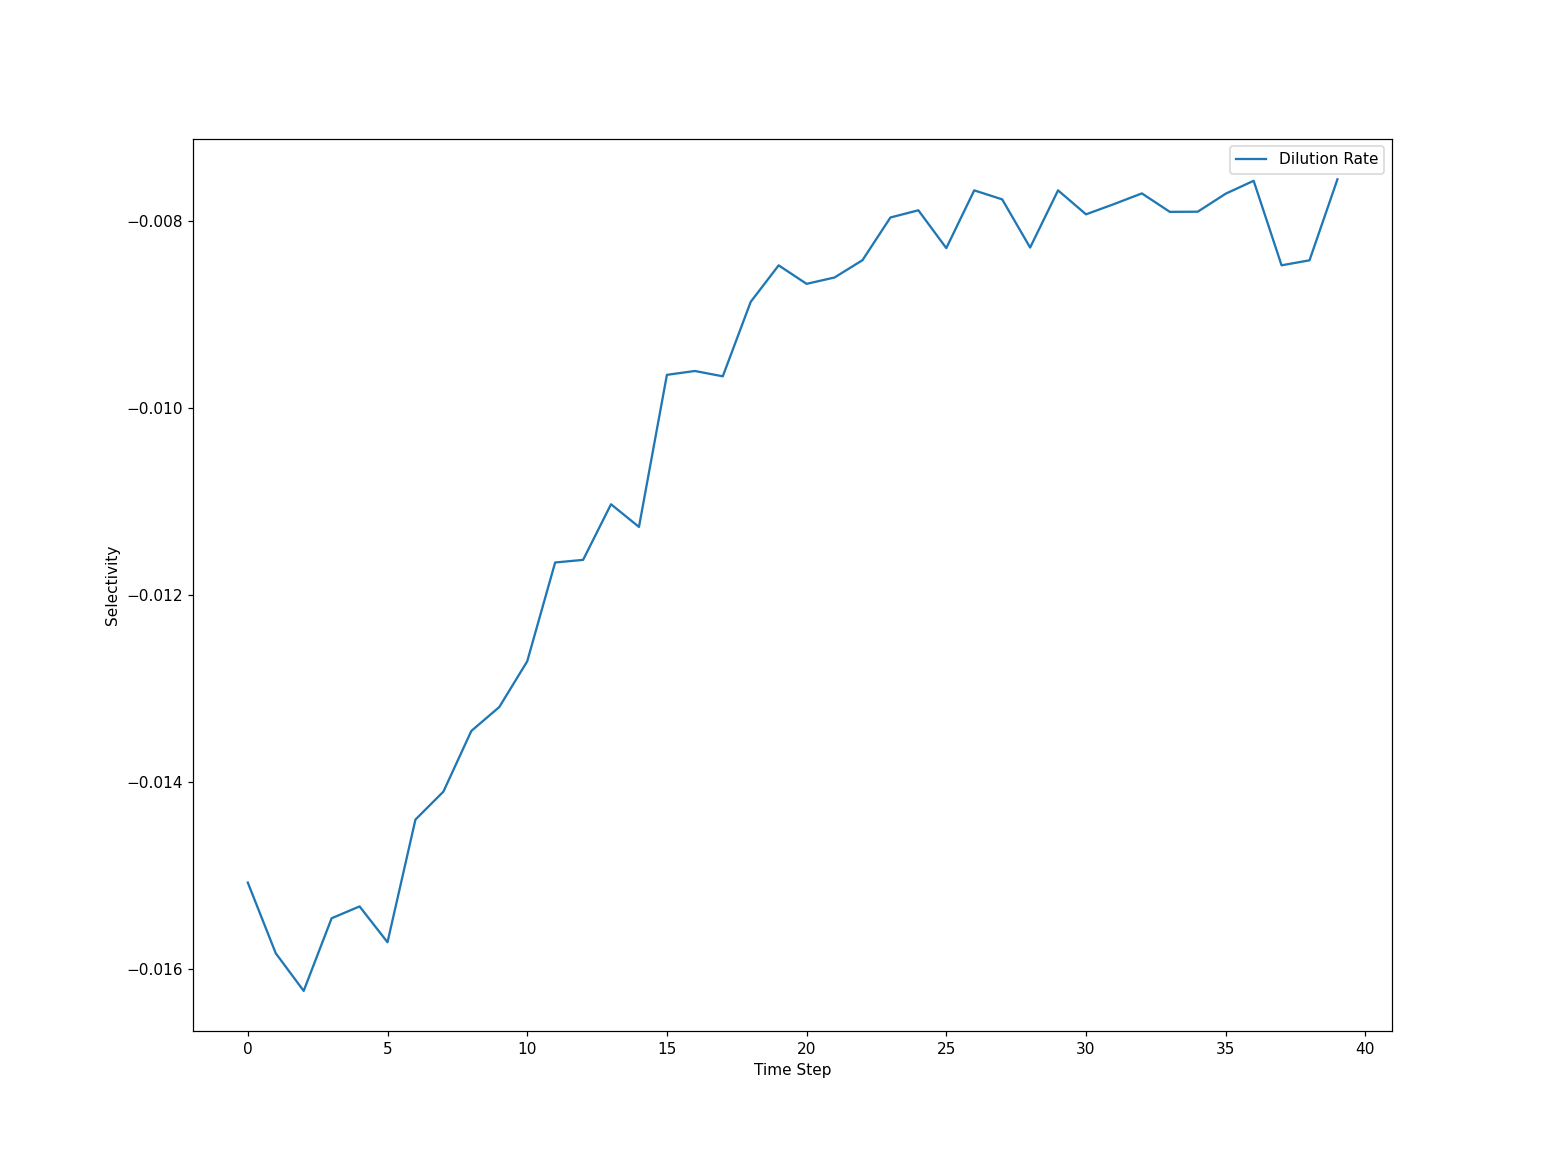

In [34]:
plt.figure(dpi=50)
plt.plot(range(0,p.Nsim), s.xOptReal[2,1:]-0.45*s.xOptReal[1,1:],label='Dilution Rate') #Should be from -inf to 0
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('Selectivity')
plt.show()

Here is the total amount of acetate mols

In [74]:
nac_arr =  p.AREA * p.L * s.uOptReal[0,:] * s.xOptReal[1,0:-1]

In [75]:
#Total number of mols produced 
sum(nac_arr) 

0.0011271957817850721

In [76]:
Wmat.shape #This is shape 8  (3 hidden layers+1 output layer)

(8,)

In [77]:
print(Wmat[6],Wmat[7])

[[ 0.0173899  -0.38503617 -0.33218876]
 [-0.6342648   0.18982098  0.2970282 ]
 [-1.0740165  -0.0156946  -0.11019058]
 [-0.92581457 -0.42855808  0.34100705]
 [-0.9135073   0.24562617 -0.6086618 ]] [0.23237522 0.0382454  0.02902538]


Now to change some of the parameters

In [57]:
Wmat[7] = np.array([0.3,0.01,0.05],dtype=float) 

In [78]:
Wmat[7][0]

0.23237522

In [71]:
Wmat[6][0][0] = 0.03
Wmat[6][1][0] = 0.03
Wmat[6][2][0] = 0.03
Wmat[6][3][0] = 0.03
Wmat[6][4][0] = 0.03

In [72]:
Wmat[6]

array([[ 0.03      ,  0.02      , -0.33218876],
       [ 0.03      ,  0.18982098,  0.2970282 ],
       [ 0.03      , -0.0156946 , -0.11019058],
       [ 0.03      , -0.42855808,  0.34100705],
       [ 0.03      ,  0.24562617, -0.6086618 ]], dtype=float32)

In [80]:
import skopt
from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer 

ModuleNotFoundError: No module named 'skopt'

In [79]:
dim_weight00 = Real(low= -1.5*Wmat[6][0][0], high=1.5*Wmat[6][0][0], prior='log-uniform',
                         name='weight00')
dim_weight10 = Real(low= -1.5*Wmat[6][1][0], high=1.5*Wmat[6][1][0], prior='log-uniform',
                         name='weight10')
dim_weight20 = Real(low= -1.5*Wmat[6][2][0], high=1.5*Wmat[6][2][0], prior='log-uniform',
                         name='weight20')
dim_weight30 = Real(low= -1.5*Wmat[6][3][0], high=1.5*Wmat[6][3][0], prior='log-uniform',
                         name='weight30')
dim_weight40 = Real(low= -1.5*Wmat[6][4][0], high=1.5*Wmat[6][4][0], prior='log-uniform',
                         name='weight40')


dim_bias0 = Real(low= -1.5*Wmat[7][0], high=1.5*Wmat[7][0], prior='log-uniform',
                         name='bias0')
dim_bias1 = Real(low= -1.5*Wmat[7][1], high=1.5*Wmat[7][1], prior='log-uniform',
                         name='bias1')
dim_bias2 = Real(low= -1.5*Wmat[7][2], high=1.5*Wmat[7][2], prior='log-uniform',
                         name='bias2')


dimensions = [dim_weight00,
              dim_weight10,
              dim_weight20,
              dim_weight30,
              dim_weight40,
              dim_bias0,
              dim_bias1,
              dim_bias2
]
default_parameters = [Wmat[6][0][0], Wmat[6][1][0], Wmat[6][2][0],Wmat[6][3][0], Wmat[6][4][0], Wmat[7][0],
                     Wmat[7][1],Wmat[7][2]]

NameError: name 'Real' is not defined

In [ ]:
@use_named_args(dimensions=dimensions)
def objective(weight00,weight10,weight20,weight30,weight40,bias0,bias1,bias2):
    
    #Gives new values to Wmat
    
    #Load the Wmat file generated after training the neural network initial model
    fileObject_load = open("weights_initialization.npy", 'rb')
    Wmat = pkl.load(fileObject_load)
    
    Wmat[6][0][0] = weight00
    Wmat[6][1][0] = weight10
    Wmat[6][2][0] = weight20
    Wmat[6][3][0] = weight30
    Wmat[6][4][0] = weight40

    Wmat[7][0]=bias0
    Wmat[7][1]=bias1
    Wmat[7][2]=bias2

    #Here solve the MPC problem
    #............................
    #
    nac_arr =  p.AREA * p.L * s.uOptReal[0,:] * s.xOptReal[1,0:-1]
    Jcost_sim = sum(nac_arr) 

    return Jcost

In [ ]:
gp_result = gp_maximize(func=objective,
                            dimensions=dimensions,
                            n_calls=11,
                            noise= 1e-8,
                            n_jobs=-1,
                            acq_func="EI",
                            x0=default_parameters)